# Sartorius 

Dit is een onderzoek naar het autmoatiseren van de annotatie op hersen cellen.
Dit onderzoek is gestart om te zorgen dat doktoren meer tijd over hebben voor andere bezigheden.

Door groep 4
Danny Rovers, Thomas Hendriks en Liam Freke

In [1]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
from warnings import filterwarnings
import tensorflow as tf
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt
import cv2
import seaborn as sns

Als eerste wordt de data opgehaald. Wij beginnen daarmee door het csv bestandt train op te halen. Dit zie je in onderstaande code.

In [3]:
pad_naar_file = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\train.csv"
type(pad_naar_file)

str

In [4]:
def read_data(csv_file):
    dataframe = pd.read_csv(csv_file)

    #zet hier de code om de CSV file in te lezen
    return dataframe

In [5]:
#hier wordt jouw functie aangeroepen en bevat df nu het dataframe
df = read_data(pad_naar_file);

In [6]:
df

,id,annotation,width,height,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,520,shsy5y,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
...,...,...,...,...,...,...,...,...,...
73580,ffdb3cc02eef,3610 3 4311 7 5014 9 5717 11 6420 13 7123 15 7...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73581,ffdb3cc02eef,341585 2 342287 5 342988 10 343690 13 344394 1...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73582,ffdb3cc02eef,47788 3 48490 7 49192 11 49896 13 50599 14 513...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00
73583,ffdb3cc02eef,333290 1 333993 2 334696 4 335399 5 336102 6 3...,704,520,cort,11h59m00s,2020-11-01,cort[debris]_D9-3_Vessel-384_Ph_4,0 days 11:59:00


Vanuit deze tabel hebben wij een data dictionary opgesteld.

### Data dictionary ###

| Variabele | Omschrijving | Datatype | Numeriek of Categorie | Meetniveau |
| :--- | :--- | :--- | :--- | :--- |
| Id | Een unieke identificatie code | Integer | Nummeriek | Ordinaal |
| annotation | gecodeerde pixels van een geïdentificeerde neuronen cell | object | Nummeriek | Ordinaal |
| width | breedte van de source image | Integer | Nummeriek | Interval |
| height | hoogte van de source image | Integer | Nummeriek | Interval |
| cell_type | Type van de cell | String | Catagorie | Nominaal |
| plate_time | Tijd van het maken van de sample | Time | Nummeriek | Interval |
| sample_date | Datum wanneer de sample is gemaakt | Date | Nummeriek | Interval |
| sample_id | Een unieke identificatie code van de sample | Integer | Catagorie | Ordinaal |
| elepased_timedelta | Tijd sinds eerste image is genomen | Date | Nummeriek | Ratio |

## Controleren van de data

Hierboven staat een deel van de data in het train csv bestandt. De data ziet er schoon uit maar wij zullen dit eerst testen voor de zekerheid. We zullen beginnen met het kijken naar de nullwaardes.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73585 entries, 0 to 73584
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 73585 non-null  object
 1   annotation         73585 non-null  object
 2   width              73585 non-null  int64 
 3   height             73585 non-null  int64 
 4   cell_type          73585 non-null  object
 5   plate_time         73585 non-null  object
 6   sample_date        73585 non-null  object
 7   sample_id          73585 non-null  object
 8   elapsed_timedelta  73585 non-null  object
dtypes: int64(2), object(7)
memory usage: 5.1+ MB


Hierboven staat de info over de tabel. Hierin staat ook dat er geen nullwaardes bevinden in de data. Verder zien we ook dat de data types van de kolommen goed staan. We zullen nu kijken naar alle unieke catagorische data.

In [8]:
df['cell_type'].unique()

array(['shsy5y', 'astro', 'cort'], dtype=object)

In [9]:
df['plate_time'].unique()

array(['11h30m00s', '09h00m00s', '13h30m00s', '19h30m00s', '07h30m00s',
       '11h59m00s', '01h30m00s', '13h00m00s'], dtype=object)

In [10]:
df['sample_date'].unique()

array(['2019-06-16', '2020-09-13', '2020-11-04', '2020-10-27',
       '2020-11-07', '2019-06-14', '2019-06-15', '2020-11-03',
       '2020-11-06', '2020-10-30', '2020-11-05', '2020-09-15',
       '2020-09-16', '2020-09-14', '2020-09-12', '2020-10-26',
       '2020-11-01', '2020-10-29'], dtype=object)

In [11]:
df['elapsed_timedelta'].unique()

array(['0 days 11:30:00', '0 days 09:00:00', '0 days 13:30:00',
       '0 days 19:30:00', '0 days 07:30:00', '0 days 11:59:00',
       '0 days 01:30:00', '0 days 13:00:00'], dtype=object)

In [12]:
df['width'].unique()

array([704], dtype=int64)

In [13]:
df['height'].unique()

array([520], dtype=int64)

In [14]:
df["id"].value_counts(normalize=False)

c4121689002f    790
d164e96bb7a9    782
e748ac1c469b    703
aff8fb4fc364    609
e8ae919aa92e    605
               ... 
7f21996da2e6      8
c25db38e918e      6
eec79772cb99      5
b861811eaff6      5
e92c56871769      4
Name: id, Length: 606, dtype: int64

In [15]:
df["sample_id"].value_counts(normalize=False)

shsy5y[diff]_E10-3_Vessel-714_Ph_4    1463
shsy5y[diff]_D11-2_Vessel-714_Ph_3    1313
shsy5y[diff]_D11-2_Vessel-714_Ph_1    1233
shsy5y[diff]_D11-1_Vessel-714_Ph_4    1230
shsy5y[diff]_D12-4_Vessel-714_Ph_4    1181
                                      ... 
cort[density]_A9-4_Vessel-376_Ph_4      11
astro[hippo]_F3-3_Vessel-361_Ph_1       10
cort[6-OHDA]_B1-2_Vessel-377_Ph_2        9
cort[6-OHDA]_G2-1_Vessel-377_Ph_4        8
astro[hippo]_H6-4_Vessel-361_Ph_4        5
Name: sample_id, Length: 403, dtype: int64

De catagorische data toont ons hoeveel verschillende waardes voorkomen.
Nu zullen wij de waardes van "cell_type" omzetten naar getallen omdat dit beter werkbaar is voor onze analyse.
De waardes "width" en "height" hebben beide maar één waarde.
De waardes "id" komt meerdere keren voor. Dit kan omdat er op meerdere pixels op de foto's van de data set markerkingen kunnen staan.
De waarde "sample_id" komt ook meerdere keren voor. Deze waarde komt vaker voor dan "id" en geeft aan dat er waarschijnlijk van een monster meerdere foto's zijn gemaakt.
Verder zien we geen andere opmerkelijke dingen in de data staan.
De andere waardes laten wij voor nu staan.

In [16]:
def vervang_categorienaam(dataframe):
    set_wc = {'shsy5y':0,'astro':1,'cort':2}
    dataframe['cell_type'] = dataframe['cell_type'].map(set_wc)
    return dataframe

In [17]:
df = vervang_categorienaam(df)

We gaan nu verder met het bekijken van de correlaties in de data.

<AxesSubplot:>

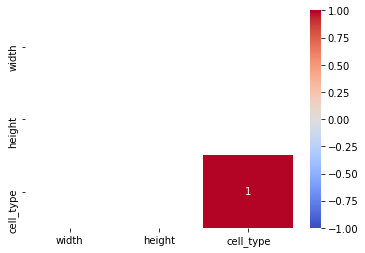

In [18]:
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

Hierboven staat een lege heatmap. Dit geeft aan dat er geen correlaties bevinden in de data. Nu zullen wij verder kijken naar de verdeling van de data we beginen met cell_type

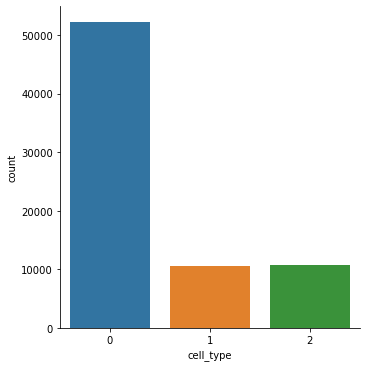

In [19]:
sns.catplot(x='cell_type', data=df,kind='count')  

Hierin valt goed te zien dat de shsy5y cell het meeste voor komt. Hierna komen de andere twee cellen die dicht bij elkaar liggen. Nu zullen we kijken naar de kolommen "elapsed_timedelta", "sample_date" en "plate_time".

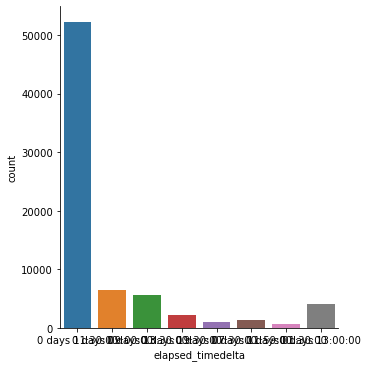

In [20]:
sns.catplot(x='elapsed_timedelta', data=df,kind='count')

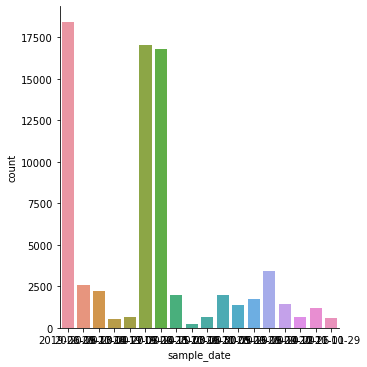

In [21]:
sns.catplot(x='sample_date', data=df,kind='count')

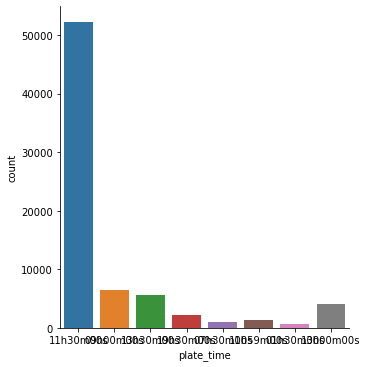

In [22]:
sns.catplot(x='plate_time', data=df,kind='count')

Bovenstaande grafieken geven aan dat de proeven of monsters vaak rond dezelfde tijd gedaan zijn. We gaan nu verder met het verwijderen van kolommen die niet nuttig zijn voor het onderzoek.

In [23]:
def verwijder(dataframe):
    dataframe = df.drop(['elapsed_timedelta'], axis=1)
    dataframe = df.drop(['sample_date'], axis=1)
    dataframe = df.drop(['plate_time'], axis=1)
    dataframe = df.drop(['width'], axis=1)
    dataframe = df.drop(['height'], axis=1)
    return dataframe

In [24]:
df = verwijder(df)

Wij hebben ervoor gekozen om de kolommen "elapsed_timedelta", "sample_date" en "plate_time" te verwijderen omdat dit tijd aangeeft. Dit hebben wij niet nodig voor oons onderzoek. 
Verder hebben wij "Width"en "height" verwijderd. Deze kolommen hebben beide maar 1 waarde en is daarom niet nuttig voor ons om mee te nemen in het onderzoek. Hieronder staat een voorbeeld van de uiteindelijke data set.

In [27]:
df.head(10)

,id,annotation,width,cell_type,plate_time,sample_date,sample_id,elapsed_timedelta
0,0030fd0e6378,118145 6 118849 7 119553 8 120257 8 120961 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
1,0030fd0e6378,189036 1 189739 3 190441 6 191144 7 191848 8 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
2,0030fd0e6378,173567 3 174270 5 174974 5 175678 6 176382 7 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
3,0030fd0e6378,196723 4 197427 6 198130 7 198834 8 199538 8 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
4,0030fd0e6378,167818 3 168522 5 169225 7 169928 8 170632 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
5,0030fd0e6378,205984 2 206687 4 207391 5 208095 5 208799 6 2...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
6,0030fd0e6378,203101 2 203805 5 204509 7 205213 10 205917 12...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
7,0030fd0e6378,191900 2 192604 3 193308 4 194012 5 194717 5 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
8,0030fd0e6378,184848 3 185551 5 186254 7 186958 8 187662 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00
9,0030fd0e6378,165119 1 165822 4 166526 6 167230 9 167935 9 1...,704,0,11h30m00s,2019-06-16,shsy5y[diff]_E10-4_Vessel-714_Ph_3,0 days 11:30:00


In [25]:
pad_naar_file2 = r"C:\Users\liamf\OneDrive - Hogeschool Leiden\Documenten\Northpool\Image_Processing\sartorius-cell-instance-segmentation\test\7ae19de7bc2a.png"
type(pad_naar_file2)

str

<dtype: 'uint8'>


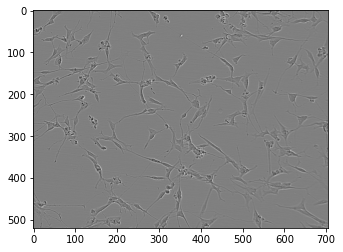

In [26]:
filterwarnings("ignore") 
tf_img = io.read_file(pad_naar_file2)
tf_img = image.decode_png(tf_img, channels=3)
print(tf_img.dtype)
plt.imshow(tf_img)